In [1]:
import sys
sys.path.append('./models')

import keras
import pickle
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from matplotlib.ticker import MaxNLocator
from utils import load_trace_dataset

from evaluation_helpers import *
from formatters import individual, windowed
from builders import evermann, sp2, pfs

##### CONFIGURATION SETUP ####
datapath = "./logs/bpic2011"
percentiles = 20
target_variable = "concept:name"
sns.set(rc={'figure.figsize':(15,10)})
### CONFIGURATION SETUP END ###

test_traces_categorical = load_trace_dataset(datapath, 'categorical', 'test')
test_traces_ordinal = load_trace_dataset(datapath, 'ordinal', 'test')
test_traces_sp2 = load_trace_dataset(datapath, 'sp2', 'test')
test_traces_pfs = load_trace_dataset(datapath, 'pfs', 'test')
test_targets = load_trace_dataset(datapath, 'target', 'test')
feature_dict = load_trace_dataset(datapath, 'mapping', 'dict')

Using TensorFlow backend.


In [2]:
_, _, evm_ind_X, evm_ind_Y = individual.format_datasets(evermann.prepare_datasets,
                                                           datapath, target_variable)
_, _, pfs_ind_X, pfs_ind_Y = individual.format_datasets(pfs.prepare_datasets,
                                                           datapath, target_variable)
_, _, sp2_ind_X, sp2_ind_Y = individual.format_datasets(sp2.prepare_datasets,
                                                        datapath, target_variable)

In [5]:
# plotting helper functions
def plot_precisions(evm_prec, sch_prec, sp2_prec, pfs_prec):
    d = {
        'Evermann et al.': evm_prec,
        'Schönig et al.':  sch_prec,
        'SP2': sp2_prec,
        'PFS': pfs_prec
    }
    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    d = pd.DataFrame(d, index=range(1,percentiles+1))

    ax = sns.lineplot(data=d, ax=ax)
    
def plot_statistics(evm_stats, sch_stats, sp2_stats, pfs_stats):
    cols = ['loss', 'val_loss','acc', 'val_acc']
    secy_cols = ['acc', 'val_acc']
    plotstyle = ['-','-','-.','-.']
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(30,15))
    axs = axs.reshape((-1))

    for i in range(3):
        axs[i].set(xlabel='Epochs', ylabel='Loss')

    evm_stats[cols].plot(secondary_y=secy_cols, kind='line', style=plotstyle, ax=axs[0]).set_title('Evermann')
    sch_stats[cols].plot(secondary_y=secy_cols, kind='line', style=plotstyle, ax=axs[1]).set_title('Schönig')
    sp2_stats[cols].plot(secondary_y=secy_cols, kind='line', style=plotstyle, ax=axs[2]).set_title('SP2')
    pfs_stats[cols].plot(secondary_y=secy_cols, kind='line', style=plotstyle, ax=axs[3]).set_title('PFS')
    
def plot_timings(t_evm, t_sch, t_sp2, t_pfs):
    d = {
        'Evermann et al.': t_evm,
        'Schönig et al.':  t_sch,
        'SP2': t_sp2,
        'PFS': t_pfs
    }
    d = pd.DataFrame(d, index=range(1,len(t_sch+1)))

    ax = sns.lineplot(data=d)
    ax.set(xlabel='Epochs', ylabel='Time (s)')

# One-trace-per-batch performance evaluation

In [3]:
evm_ind_model = keras.models.load_model("../docker_share/bpic2011/evermann_individual.hdf5")
sch_ind_model = keras.models.load_model("../docker_share/bpic2011/schoenig_individual.hdf5")
sp2_ind_model = keras.models.load_model("../docker_share/bpic2011/sp2_individual.hdf5")
pfs_ind_model = keras.models.load_model("../docker_share/bpic2011/pfs_individual.hdf5")

evm_ind_precisions = calculate_percentile_precisions(evm_ind_model, evm_ind_X, evm_ind_Y, percentiles)
sch_ind_precisions = calculate_percentile_precisions(sch_ind_model, sp2_ind_X, sp2_ind_Y, percentiles)
sp2_ind_precisions = calculate_percentile_precisions(sp2_ind_model, sp2_ind_X, sp2_ind_Y, percentiles)
pfs_ind_precisions = calculate_percentile_precisions(pfs_ind_model, pfs_ind_X, pfs_ind_Y, percentiles)

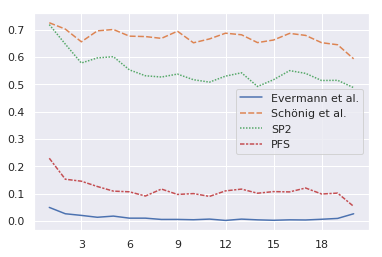

In [7]:
plot_precisions(evm_ind_precisions, sch_ind_precisions, sp2_ind_precisions, pfs_ind_precisions)

# One-trace-per-batch training statistics

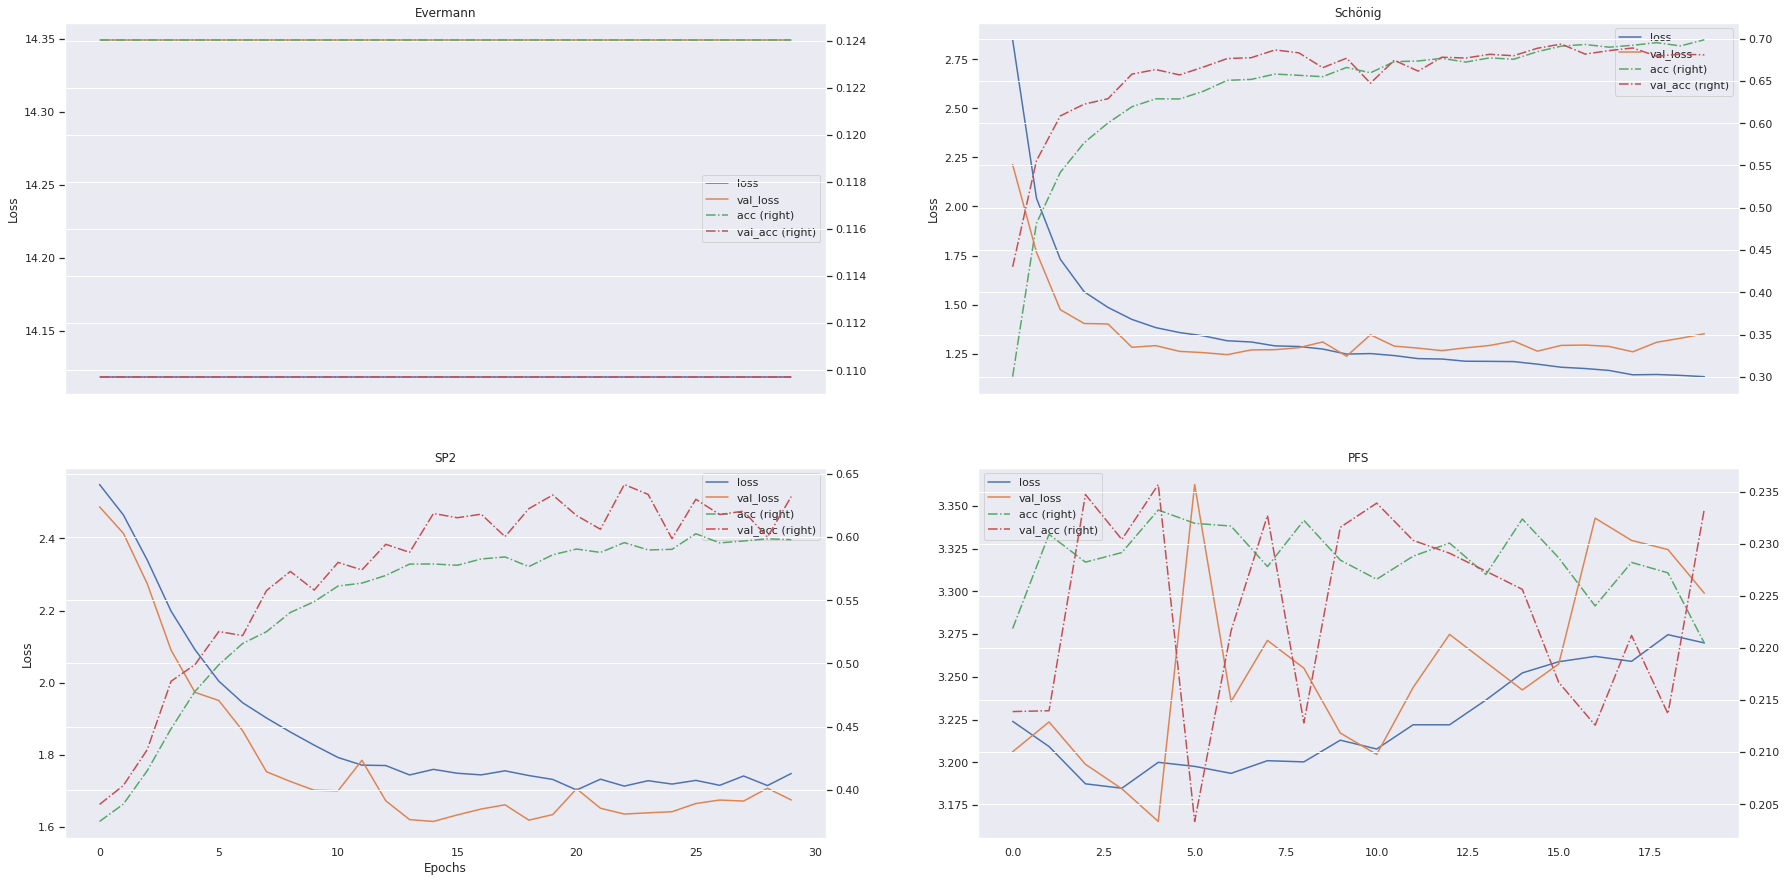

In [14]:
evm_ind_stats = pd.read_pickle('/home/felix.wolff2/docker_share/bpic2011/evermann_individual_stats.pickled')
sch_ind_stats = pd.read_pickle('/home/felix.wolff2/docker_share/bpic2011/schoenig_individual_stats.pickled')
sp2_ind_stats = pd.read_pickle('/home/felix.wolff2/docker_share/bpic2011/sp2_individual_stats.pickled')
pfs_ind_stats = pd.read_pickle('/home/felix.wolff2/docker_share/bpic2011/pfs_individual_stats.pickled')

plot_statistics(evm_ind_stats, sch_ind_stats, sp2_ind_stats, pfs_ind_stats)

# One-trace-per-batch training timings

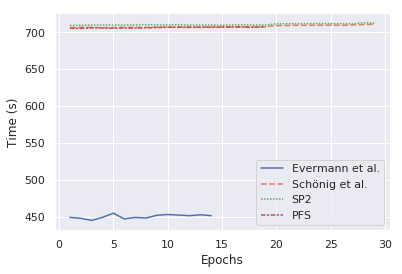

In [13]:
plot_timings(evm_ind_stats['training_time'], sch_ind_stats['training_time'], sp2_ind_stats['training_time'], pfs_ind_stats['training_time'])

# Traces-grouped-by-length-into-batch evaluation

In [ ]:
evm_grp_stats = pd.read_pickle('/home/felix.wolff2/docker_share/bpic2011/evermann_grouped_stats.pickled')[:-1]
sch_grp_stats = pd.read_pickle('/home/felix.wolff2/docker_share/bpic2011/schoenig_grouped_stats.pickled')[:-1]
sp2_grp_stats = pd.read_pickle('/home/felix.wolff2/docker_share/bpic2011/sp2_grouped_stats.pickled')[:-1]
pfs_grp_stats = pd.read_pickle('/home/felix.wolff2/docker_share/bpic2011/pfs_grouped_stats.pickled')[:-1]

evm_grp_precisions, sch_grp_precisions, sp2_grp_precisions, pfs_grp_precision = grouped_percentile_calculation(evm_model, sch_model, sp2_model, pfs_model)

In [ ]:
plot_precisions(evm_grp_precisions, sch_grp_precisions, sp2_grp_precisions, pfs_grp_precision)

# Traces-grouped-by-length-into-batch training statistics

In [15]:
evm_grp_stats = pd.read_pickle('/home/felix.wolff2/docker_share/bpic2011/evermann_grouped_stats.pickled')
sch_grp_stats = pd.read_pickle('/home/felix.wolff2/docker_share/bpic2011/schoenig_grouped_stats.pickled')
sp2_grp_stats = pd.read_pickle('/home/felix.wolff2/docker_share/bpic2011/sp2_grouped_stats.pickled')
pfs_grp_stats = pd.read_pickle('/home/felix.wolff2/docker_share/bpic2011/pfs_grouped_stats.pickled')

plot_statistics(evm_grp_stats, sch_grp_stats, sp2_grp_stats, pfs_grp_stats)

FileNotFoundError: [Errno 2] No such file or directory: '/home/felix.wolff2/docker_share/bpic2011/schoenig_grouped_stats.pickled'

# Traces-grouped-by-length-into-batch training timings

In [ ]:
plot_timings(evm_grp_stats['training_time'], sch_grp_stats['training_time'], sp2_grp_stats['training_time'], pfs_grp_stats['training_time'])

# Traces-padded-to-fixed-length evaluation

In [ ]:
evm_model = keras.models.load_model("../../docker_share/evermann/padded/best_val_loss_e50.hdf5")
sch_model = keras.models.load_model("../../docker_share/schoenig/padded/best_val_loss_e41.hdf5")
sp2_model = keras.models.load_model("../../docker_share/sp2/padded/best_val_loss_e35.hdf5")
pfs_model = keras.models.load_model("../../docker_share/pfs/padded/best_val_loss_e18.hdf5")

evm_pad_precisions, sch_pad_precisions, sp2_pad_precisions, pfs_pad_precision = grouped_percentile_calculation(evm_model, sch_model, sp2_model, pfs_model)

In [ ]:
plot_precisions(evm_pad_precisions, sch_pad_precisions, sp2_pad_precisions, pfs_pad_precision)

# Traces-padded-to-fixed-length training statistics

In [ ]:
evm_pad_stats = pd.read_pickle('/home/felix.wolff2/docker_share/evermann/padded/train_statistics.pickled')
sch_pad_stats = pd.read_pickle('/home/felix.wolff2/docker_share/schoenig/padded/train_statistics.pickled')
sp2_pad_stats = pd.read_pickle('/home/felix.wolff2/docker_share/sp2/padded/train_statistics.pickled')
pfs_pad_stats = pd.read_pickle('/home/felix.wolff2/docker_share/pfs/padded/train_statistics.pickled')

plot_statistics(evm_pad_stats, sch_pad_stats, sp2_pad_stats, pfs_pad_stats)

# Traces-padded-to-fixed-length training timings

In [ ]:
plot_timings(evm_pad_stats['training_time'], sch_pad_stats['training_time'], sp2_pad_stats['training_time'], pfs_pad_stats['training_time'])

# Work in progress

# Schönig feature importance evaluation

In [ ]:
# sklearn is (not yet?) able to permute 3-D input or 2-D input. Thus
def generate_score_function(model, input_shape):
    def score_model(x, y):
        t_acc = 0
        y_hat = model.predict(x.reshape(input_shape))[0]

        for i in range(0,len(y)): # loop through predicted next steps and compare
            # infer one-hot encoding and check if a prediction has been made correctly
            if np.argmax(y_hat[i]) == np.argmax(y[i]):
                t_acc += 1

        return t_acc / len(x)
    return score_model

n_tests = 10#len(schoenig_input_batches)
base_scores = [None] * n_tests
score_decreases = [None] * n_tests
feature_importances = [None] * n_tests

for i in range(0, n_tests):
    base_scores[i], score_decreases[i] = get_score_importances(generate_score_function(schoenig_model,
                                                                            (1,-1,n_train_cols)),
                                                    schoenig_input_batches[i],
                                                    schoenig_target_batches[i])
    feature_importances[i] = np.mean(score_decreases[i], axis=0)
    
sum(feature_importances) / n_tests